El siguiente código presenta un tratamiento y análisis de transporte de pasajeros de transporte terrestre en Colombia desde el años 2019.
La data proviene del recurso público https://www.datos.gov.co/Transporte/Operaci-n-de-pasajeros-y-despacho-de-veh-culos-en-/eh75-8ah6, y el documento de códificación de municipios desde https://geoportal.dane.gov.co/geovisores/territorio/consulta-divipola-division-politico-administrativa-de-colombia/

La explicación de observaciones se evidencia en puntos específicos y después de algunas gráficas realizadas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import requests
from io import StringIO
from openpyxl import load_workbook
from io import BytesIO

# **Exportación y preprocesamiento de datos**

Antes de comenzar con el trabajo de análisis se implementará un primer tratamiento que constará de agregar los datos de DIVIPOLA extraidos del DANE al archivo de operación terrestre extraido de Datos.gov

In [2]:
#Datos directamente desde la API
# Definir la URL base
base_url = "https://www.datos.gov.co/resource/eh75-8ah6.csv"
response = requests.get(base_url)


# Obtener el año actual
current_year = pd.to_datetime("today").year

# Crear una lista para almacenar los DataFrames por año
dataframes = []

# Iterar a través de los años desde 2019 hasta el año actual
for year in range(2019, current_year + 1):
    # Construir la URL para el año actual
    year_url = f"{base_url}?$where=fecha_despacho between '{year}-01-01T00:00:00' and '{year}-12-31T00:00:00'&$limit=10000000"
    # Realizar una solicitud GET a la URL y obtener el contenido del CSV
    response = requests.get(year_url)
    
    # Crear un DataFrame a partir del contenido del CSV
    df = pd.read_csv(StringIO(response.text))
    
    # Agregar el DataFrame a la lista
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)
data.columns = map(str.upper, data.columns)
# Ahora tienes todos los datos en full_data
print(data.head())

         TERMINAL CLASE_VEHICULO NIVEL_SERVICIO  MUNICIPIO_ORIGEN_RUTA  \
0  T.T. DE MAICAO            BUS           LUJO                  44430   
1  T.T. DE QUIBDO       MICROBUS         BASICO                  27001   
2  T.T. DE MAICAO            BUS           LUJO                  44430   
3  T.T. DE QUIBDO       MICROBUS         BASICO                  27001   
4  T.T. DE MAICAO            BUS           LUJO                  44430   

   MUNICIPIO_DESTINO_RUTA           FECHA_DESPACHO  HORA_DESPACHO  \
0                    5001  2019-01-01T00:00:00.000             14   
1                    5001  2019-01-01T00:00:00.000              9   
2                   13001  2019-01-01T00:00:00.000             11   
3                   66001  2019-01-01T00:00:00.000             17   
4                    8001  2019-01-01T00:00:00.000             15   

  TIPO_DESPACHO  DESPACHOS  PASAJEROS  
0        ORIGEN          1         16  
1        ORIGEN          1          0  
2        ORIGEN     

In [3]:
#Revisar cantidad de datos extraidos y otras distribuciones
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63177087 entries, 0 to 63177086
Data columns (total 10 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   TERMINAL                object
 1   CLASE_VEHICULO          object
 2   NIVEL_SERVICIO          object
 3   MUNICIPIO_ORIGEN_RUTA   int64 
 4   MUNICIPIO_DESTINO_RUTA  int64 
 5   FECHA_DESPACHO          object
 6   HORA_DESPACHO           int64 
 7   TIPO_DESPACHO           object
 8   DESPACHOS               int64 
 9   PASAJEROS               int64 
dtypes: int64(5), object(5)
memory usage: 4.7+ GB


In [4]:
print(data.dtypes) #Revisar tipo de datos desde .json

TERMINAL                  object
CLASE_VEHICULO            object
NIVEL_SERVICIO            object
MUNICIPIO_ORIGEN_RUTA      int64
MUNICIPIO_DESTINO_RUTA     int64
FECHA_DESPACHO            object
HORA_DESPACHO              int64
TIPO_DESPACHO             object
DESPACHOS                  int64
PASAJEROS                  int64
dtype: object


In [5]:
#Convertir datos con base a requerimientos y revisar nuevamente
data['MUNICIPIO_ORIGEN_RUTA'] = data['MUNICIPIO_ORIGEN_RUTA'].astype(int)
data['MUNICIPIO_DESTINO_RUTA'] = data['MUNICIPIO_DESTINO_RUTA'].astype(int)
data['HORA_DESPACHO'] = data['HORA_DESPACHO'].astype(int)
data['DESPACHOS'] = data['DESPACHOS'].astype(int)
data['PASAJEROS'] = data['PASAJEROS'].astype(int)

#Revisar conversiones 
print(data.dtypes)

TERMINAL                  object
CLASE_VEHICULO            object
NIVEL_SERVICIO            object
MUNICIPIO_ORIGEN_RUTA      int32
MUNICIPIO_DESTINO_RUTA     int32
FECHA_DESPACHO            object
HORA_DESPACHO              int32
TIPO_DESPACHO             object
DESPACHOS                  int32
PASAJEROS                  int32
dtype: object


In [6]:
#Leer documento de despacho de pasajeros terrestres y visualizar los primeros renglones de este documento

#data = pd.read_csv('D:\Descargas\Operaci_n_de_pasajeros_y_despacho_de_veh_culos_en_la_modalidad_de_transporte_de_pasajeros_por_carretera1.csv', encoding="utf-8")

#Debido a un dato de tipo incorrecto sobre una de las columnas en esta versión del archivo, es necesario implementar
#la conversión de dato antes de continuar con el proceso de análisis, la conversión directa con el reemplazo genera problemas
#al querer realizar operaciones matemáticas sobre este campo
#def replace_comma(value):
#    if isinstance(value, str) and ',' in value and '.' not in value:
#        return float(value.replace(',', ''))
#    return value  #Al requerir ser string para reemplazo de carácteres no númericos, se implementan los reemplazos para volver a formato numérico ideal#

#data['PASAJEROS'] = data['PASAJEROS'].apply(replace_comma)
#data['PASAJEROS'] = data['PASAJEROS'].astype(int)
#print(data.dtypes)
#data.head()

In [7]:
#Poseemos un documento con la códificación interna de los municipios y departamentos del país, el cual podemos implementar
#y realizar análisis con mayor claridad y personalización

#Leer documento de excel que contiene códigos de municipios y poder transformar coincidencia en el documento anterior
#municipios_nombre = pd.read_excel('d:\Descargas\DIVIPOLA_Municipios.xlsx', sheet_name="Hoja1")
#municipios_nombre.head()

url = "https://geoportal.dane.gov.co/descargas/divipola/DIVIPOLA_Municipios.xlsx"

response = requests.get(url)
if response.status_code == 200:
    with BytesIO(response.content) as buffer:
        workbook = load_workbook(buffer)
        sheet = workbook.active

        # Encuentra la primera fila que contiene datos y finaliza al final del contenido deseado
        first_data_row = 11
        last_row = 1132

        # Convierte la hoja de Excel en un DataFrame de Pandas, omitiendo las filas anteriores
        municipios_nombre = pd.DataFrame(sheet.iter_rows(values_only=True, min_row=first_data_row, max_row=last_row))
        
        # Asegúrate de que los encabezados de columna se configuren adecuadamente si no están en la primera fila.

        # Ahora puedes trabajar con el DataFrame df
else:
    print(f"Failed to download Excel file. Status code: {response.status_code}")

# Después de crear el DataFrame df
municipios_nombre.columns = municipios_nombre.iloc[0]

# Luego, elimina la primera fila, ya que se ha convertido en el título de las columnas
municipios_nombre = municipios_nombre.iloc[1:]

#En este primer formato de extracción existen columnas con nombre duplicado
#Así que es necesario renombrarla correctamente para la unión con el otro dataframe
# Encuentra las columnas duplicadas
duplicadas = municipios_nombre.columns[municipios_nombre.columns.duplicated()].tolist()

# Renombra las columnas duplicadas de manera única
for duplicada in duplicadas:
    indices = [i for i, col in enumerate(municipios_nombre.columns) if col == duplicada]
    for i, index in enumerate(indices):
        if i > 0:
            municipios_nombre.columns.values[index] = f"{duplicada}_{i}"

# Ahora puedes renombrar las columnas como desees
municipios_nombre = municipios_nombre.rename(columns={"Código " : "CódigoDepartamento",
                                                      "Nombre" : "NombreDepartamento",
                                                      "Código _1" : "CódigoMunicipio",
                                                      "Nombre_1" : "NombreMunicipio"})

municipios_nombre["CódigoMunicipio"] = municipios_nombre["CódigoMunicipio"].astype(int)

municipios_nombre.head(20)


,CódigoDepartamento,NombreDepartamento,CódigoMunicipio,NombreMunicipio,None,Longitud,Latitud,None_1
1,05,ANTIOQUIA,5001,MEDELLÍN,Municipio,"-75,581775","6,246631",None
2,05,ANTIOQUIA,5002,ABEJORRAL,Municipio,"-75,428739","5,789315",None
3,05,ANTIOQUIA,5004,ABRIAQUÍ,Municipio,"-76,064304","6,632282",None
4,05,ANTIOQUIA,5021,ALEJANDRÍA,Municipio,"-75,141346","6,376061",None
5,05,ANTIOQUIA,5030,AMAGÁ,Municipio,"-75,702188","6,038708",None
6,05,ANTIOQUIA,5031,AMALFI,Municipio,"-75,077501","6,909655",None
7,05,ANTIOQUIA,5034,ANDES,Municipio,"-75,878828","5,657194",None
8,05,ANTIOQUIA,5036,ANGELÓPOLIS,Municipio,"-75,711389","6,109719",None
9,05,ANTIOQUIA,5038,ANGOSTURA,Municipio,"-75,335116","6,885175",None
10,05,ANTIOQUIA,5040,ANORÍ,Municipio,"-75,148355","7,074703",None


In [8]:
print(municipios_nombre.dtypes)

0
CódigoDepartamento    object
NombreDepartamento    object
CódigoMunicipio        int32
NombreMunicipio       object
None                  object
Longitud              object
Latitud               object
None_1                object
dtype: object


In [9]:
# Realizar el mapeo del código con el municipio y departamento
codigo_municipio_map = dict(zip(municipios_nombre['CódigoMunicipio'], municipios_nombre['NombreMunicipio']))
codigo_departamento_map = dict(zip(municipios_nombre['CódigoMunicipio'], municipios_nombre['NombreDepartamento']))

#print(codigo_departamento_map)
#print(codigo_municipio_map)

#Agregar nombre al documento de trasnporte terrestre con la coincidencia de códigos
data['MUNICIPIO_DESTINO'] = data['MUNICIPIO_DESTINO_RUTA'].map(codigo_municipio_map)
data['DEPARTAMENTO_DESTINO'] = data['MUNICIPIO_DESTINO_RUTA'].map(codigo_departamento_map)
data['MUNICIPIO_ORIGEN'] = data['MUNICIPIO_ORIGEN_RUTA'].map(codigo_municipio_map)
data['DEPARTAMENTO_ORIGEN'] = data['MUNICIPIO_ORIGEN_RUTA'].map(codigo_departamento_map)

#Muestra de la nueva transformación
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,MUNICIPIO_ORIGEN_RUTA,MUNICIPIO_DESTINO_RUTA,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,44430,5001,2019-01-01T00:00:00.000,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE QUIBDO,MICROBUS,BASICO,27001,5001,2019-01-01T00:00:00.000,9,ORIGEN,1,0,MEDELLÍN,ANTIOQUIA,QUIBDÓ,CHOCÓ
2,T.T. DE MAICAO,BUS,LUJO,44430,13001,2019-01-01T00:00:00.000,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
3,T.T. DE QUIBDO,MICROBUS,BASICO,27001,66001,2019-01-01T00:00:00.000,17,ORIGEN,1,0,PEREIRA,RISARALDA,QUIBDÓ,CHOCÓ
4,T.T. DE MAICAO,BUS,LUJO,44430,8001,2019-01-01T00:00:00.000,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA


Antes de continuar, debido al contexto de Python es necesario convertir correctamente algunos campos que desde el origen pueden presentarnos problema en el desarrollo de análisis

In [ ]:
#Es necesario agregar un paso extra para convertir correctamente el campo de fecha al fromato deseado
#ya que la hora presente en este campo está erronéa a comparación de HORA DESPACHO
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['FECHA_DESPACHO'] = data['FECHA_DESPACHO'].dt.date
data.head()
#data.to_csv('Transporte Pasajeros 2019-2023.csv') #habilitar opción para descargar un csv "limpio" e implementarse en herramientas de visualización

In [11]:
#Limpieza de datos rehundantes en el conjunto
#Eliminar las columnas originales de municipios de origen y municipios de destino del archivo
columnas_a_eliminar = ['MUNICIPIO_ORIGEN_RUTA', 'MUNICIPIO_DESTINO_RUTA']
data.drop(columnas_a_eliminar, axis=1, inplace=True)
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,2019-01-01,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE QUIBDO,MICROBUS,BASICO,2019-01-01,9,ORIGEN,1,0,MEDELLÍN,ANTIOQUIA,QUIBDÓ,CHOCÓ
2,T.T. DE MAICAO,BUS,LUJO,2019-01-01,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
3,T.T. DE QUIBDO,MICROBUS,BASICO,2019-01-01,17,ORIGEN,1,0,PEREIRA,RISARALDA,QUIBDÓ,CHOCÓ
4,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA


In [12]:
#Revisamos nuevamente el tipo de dato de cada columna y verificamos el tipo de las 2 columnas númericas de mayor uso
#Pasajeros y Despachos, pues son las principales referencias para el problema
print(data.dtypes)

TERMINAL                object
CLASE_VEHICULO          object
NIVEL_SERVICIO          object
FECHA_DESPACHO          object
HORA_DESPACHO            int32
TIPO_DESPACHO           object
DESPACHOS                int32
PASAJEROS                int32
MUNICIPIO_DESTINO       object
DEPARTAMENTO_DESTINO    object
MUNICIPIO_ORIGEN        object
DEPARTAMENTO_ORIGEN     object
dtype: object


# **Análisis de datos**

Una vez con los arreglos aplicados, se puede empezar a trabajar con la parte exploratoria y descriptiva de los datos extraídos

In [13]:
#Observamos una estadística descriptiva sobre los datos en las variables más importantes
data.describe()

,HORA_DESPACHO,DESPACHOS,PASAJEROS
count,6.317709e+07,6.317709e+07,6.317709e+07
mean,1.205749e+01,1.031236e+00,8.298955e+00
std,4.871279e+00,2.220885e-01,8.291747e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,8.000000e+00,1.000000e+00,2.000000e+00
50%,1.200000e+01,1.000000e+00,6.000000e+00
75%,1.600000e+01,1.000000e+00,1.200000e+01
max,2.300000e+01,2.000000e+01,6.400000e+02


In [14]:
#Al observar que hay pasajeros con un valor mínimo de 0, son valores innecesarios dentro del dataframe en el contexto de análisis.
#Por cual se contará la cantidad de filas con este valor y luego se eliminarán estas.
Pasajeros0 = (data['PASAJEROS']==0).sum()
print('Cantidad de viajes con 0 parasajeros', Pasajeros0)
filastotales = data.shape[0]
print('Tamaño total del conjunto', filastotales)
print('razón pasajeros 0 sobre total', (Pasajeros0/filastotales))

Cantidad de viajes con 0 parasajeros 9478651
Tamaño total del conjunto 63177087
razón pasajeros 0 sobre total 0.15003304916543556


In [15]:
#Explicación de razón de datos 0 del documento
razon_en_porcentaje = round((Pasajeros0/filastotales)*100, 2)
print(f'Si bien es un alto número de regitros con pasajeros 0, marca sólo un {razon_en_porcentaje}% del total de estos, por lo cual se pueden eliminar estos valores del connjunto general de datos')

Si bien es un alto número de regitros con pasajeros 0, marca sólo un 15.0% del total de estos, por lo cual se pueden eliminar estos valores del connjunto general de datos


In [16]:
#Estos registros no son de gran relevancia para el caso, dado que el contexto PB se enfoca sobre el transporte de pasajeros entre ciudades
data = data.drop(data[data['PASAJEROS']==0].index)
data.shape[0]
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,2019-01-01,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,2019-01-01,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
7,T.T. DE MAICAO,BUS,LUJO,2019-01-01,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
8,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


In [17]:
#Para simplificar el proceso de agrupación de las variables de Pasajero y Despacho se creará la siguiente variable
def grupo_por_columna(dt, columna_agrupada):
    #   Agrupar datos en resumen de suma
    agrupacion = dt.groupby(columna_agrupada).agg({'PASAJEROS': 'sum', 'DESPACHOS': 'sum'}).reset_index()
    return agrupacion

In [18]:
#La agrupación de las 2 variables principales representan cantidades grandes para el formato de Python y Jupyter
#Entonces se agrega la conjetura a etiquetas de los gráficos a generar en las siguientes líneas
def formato_ejes(x, pos):
    return f'{int(x/1e6)}M'


In [19]:
#Adicional se calculará el total general de Pasajeros y Despachos para contemplar propociones de las agrupaciones a generar
total_pasajeros = data['PASAJEROS'].sum()
total_despachos = data['DESPACHOS'].sum()
pasajero_prom_por_despacho = (total_pasajeros/total_despachos).round(2)

print('Total Pasajeros:', total_pasajeros)
print('Total Despachos:', total_despachos)
print('Pasajero promedio por Despacho:', pasajero_prom_por_despacho)

Total Pasajeros: 524303793
Total Despachos: 55295690
Pasajero promedio por Despacho: 9.48


### Histórico de despachos y pasajeros por mes-año

Tomaremos de incio, análizar el comportamiento histórico de la data registrada

    MES-AÑO  PASAJEROS  DESPACHOS  Variación Despachos(%)  \
0   2019-01      55096       3311                     NaN   
1   2019-02      19156       1466                  -55.72   
2   2019-03        110          3                  -99.80   
3   2019-04        895         55                 1733.33   
4   2019-05      32625       2923                 5214.55   
..      ...        ...        ...                     ...   
69  2025-03    9284715     958452                    8.92   
70  2025-04   13735809    1340919                   39.90   
71  2025-05    9358355     992085                  -26.01   
72  2025-06   20441679    1945561                   96.11   
73  2025-07   10072541     964287                  -50.44   

    Variación Pasajeros (%)  
0                       NaN  
1                    -65.23  
2                    -99.43  
3                    713.64  
4                   3545.25  
..                      ...  
69                     9.28  
70                    47.94

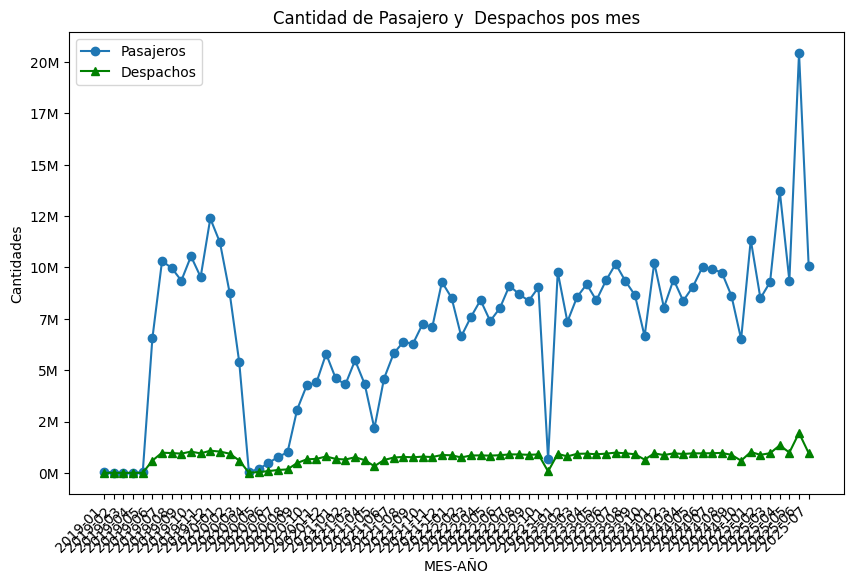

In [20]:
#Primero será necesario agrupar los datos por mes-año según Fecha Despacho
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['MES-AÑO'] = data['FECHA_DESPACHO'].dt.to_period('M')
data_agrupada = grupo_por_columna(data, 'MES-AÑO')


data_agrupada['Variación Despachos(%)'] = (data_agrupada['DESPACHOS'].pct_change() * 100).round(2)
data_agrupada['Variación Pasajeros (%)'] = (data_agrupada['PASAJEROS'].pct_change() * 100).round(2)

print(data_agrupada)
print(data_agrupada)
data_agrupada['MES-AÑO'] = data_agrupada['MES-AÑO'].astype(str)

#Graficar los datos
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.plot(data_agrupada['MES-AÑO'], data_agrupada['PASAJEROS'], label = 'Pasajeros', marker = 'o')
plt.plot(data_agrupada['MES-AÑO'], data_agrupada['DESPACHOS'], label = 'Despachos', marker = '^', color='green')
ax.yaxis.set_major_formatter(FuncFormatter(formato_ejes))
plt.xlabel('MES-AÑO')
plt.ylabel('Cantidades')
plt.title('Cantidad de Pasajero y  Despachos pos mes')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Ya que estamos observando la data con base en un rango de 4 años, es interesante poder observar los máximos y mínimos de este, aunque de entrada se observa que los datos del último mes registrado del 2024 (año actual) aun están incompletos lo ideal es rescatar el menor valor sin contemplar este mes sin finalizar. Gracias a la gráfica anterior, el patrón de ambos valores es el mismo, por lo cual se observará el mínimo y máximo de ambos valores independientes en los mismos meses.

In [21]:
#Contempletar datos agrupados sin el último mes en cuestión
data_agrupada_sin_último_mes = data_agrupada.iloc[:-1]

# mes con el menor y mayor cantidad de despachos
mes_menor_despachos = data_agrupada_sin_último_mes.loc[data_agrupada_sin_último_mes['DESPACHOS'].idxmin()]
mes_mayor_despachos = data_agrupada.loc[data_agrupada['DESPACHOS'].idxmax()]

# Extraer los pasajeros según el mínimo anterior
pasajeros_menor_despacho = mes_menor_despachos['PASAJEROS']
pasajeros_mayor_despacho = mes_mayor_despachos['PASAJEROS']

#Imprimir y observar resúltados
print(f"Mes con el mínimo general: {mes_menor_despachos['MES-AÑO']}, Despachos: {mes_menor_despachos['DESPACHOS']}, Pasajeros: {pasajeros_menor_despacho}")
print(f"Mes con el máximo general: {mes_mayor_despachos['MES-AÑO']}, Despachos: {mes_mayor_despachos['DESPACHOS']}, Pasajeros: {pasajeros_mayor_despacho}")


Mes con el mínimo general: 2019-03, Despachos: 3, Pasajeros: 110
Mes con el máximo general: 2025-06, Despachos: 1945561, Pasajeros: 20441679


De entrada, el histórico, que nos muestra datos desde los últimos 4 meses del 2019 hasta el mes casi actual del presente año. Se evidencia que la pandemía afectó en gran medida el transporte terrestre de pasajeros. Gracias el máximo y mínimo, se observa que no se ha logrado romper el máximo histórico después de pandemia, lo cuál parece que el viaje a través de terminales terrestres aun requiere esfuerzos para volver a obtener alto tráfico, o existen más autos familiares en carreteras nacionales. No obstante, el año 2023 comenzó casi acercandose a este máximo hitórico, lo cuál debió incrementar esperanzas en las compañías de transporte sobre la expectativas de viaje para este año.

Adicional, como se mencionó antes, el patrón de demanda y oferta de transporte es cohorente y sugiere que se abarca en mejor medida en todo el tiempo recorrido

In [22]:
#Correlación Despachos-Pasajeros
corr = round(data['PASAJEROS'].corr(data['DESPACHOS']), 4)

print(f'Las 2 variables principales entregan una correlación de {corr} lo cual implica que tienden a ser directamente proporcionales entre sí')

Las 2 variables principales entregan una correlación de 0.2403 lo cual implica que tienden a ser directamente proporcionales entre sí


### Variación anual Despachos y Pasajeros
Ya vista la tendencia general en cada uno de los meses presentes en el conjunto de datos, podemos entrar en más detalle sobre esto, observando ésta a nivel de Departamento de Origen, en cuestión anual

In [23]:
#Agrupar la data por fecha de despacho considerando únicamente el año
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['AÑO'] = data['FECHA_DESPACHO'].dt.to_period('Y')

#Se agrupa y se presenta en tabla, agregando la varión año a año para cada variable
tendencia_anual_por_departamento = grupo_por_columna(data, ['DEPARTAMENTO_ORIGEN', 'AÑO'])
tendencia_anual_por_departamento['Pasajeros YoY'] = (tendencia_anual_por_departamento.groupby('DEPARTAMENTO_ORIGEN')['PASAJEROS'].pct_change()*100).round(2)
tendencia_anual_por_departamento['Despachos YoY'] = (tendencia_anual_por_departamento.groupby('DEPARTAMENTO_ORIGEN')['DESPACHOS'].pct_change()*100).round(2)
print(tendencia_anual_por_departamento)

#En este punto es necesario indagar en cómo evitar el resultado de variación para años no consecutivos

    DEPARTAMENTO_ORIGEN   AÑO  PASAJEROS  DESPACHOS  Pasajeros YoY  \
0             ANTIOQUIA  2019    7266118     642772            NaN   
1             ANTIOQUIA  2020    6109309     733044         -15.92   
2             ANTIOQUIA  2021    9458314    1083258          54.82   
3             ANTIOQUIA  2022   10436875    1001932          10.35   
4             ANTIOQUIA  2023   11664514    1061567          11.76   
..                  ...   ...        ...        ...            ...   
184     VALLE DEL CAUCA  2021    9973877    1260296          28.62   
185     VALLE DEL CAUCA  2022   12631651    1336801          26.65   
186     VALLE DEL CAUCA  2023   12401792    1341997          -1.82   
187     VALLE DEL CAUCA  2024   12595867    1322688           1.56   
188     VALLE DEL CAUCA  2025   11747435    1170973          -6.74   

     Despachos YoY  
0              NaN  
1            14.04  
2            47.78  
3            -7.51  
4             5.95  
..             ...  
184         

In [24]:
#Adicional podemos observar la tendencia mensual para cada departamento de origen
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['MES'] = data['FECHA_DESPACHO'].dt.to_period('M')


#Calcular la variación interanual de las variables por Departamento de Origen
tendencia_anual_por_departamento_mes = grupo_por_columna(data, ['DEPARTAMENTO_ORIGEN', 'MES'])
tendencia_anual_por_departamento_mes['Pasajeros MoM'] = (tendencia_anual_por_departamento_mes.groupby('DEPARTAMENTO_ORIGEN')['PASAJEROS'].pct_change()*100).round(2)
tendencia_anual_por_departamento_mes['Despachos MoM'] = (tendencia_anual_por_departamento_mes.groupby('DEPARTAMENTO_ORIGEN')['DESPACHOS'].pct_change()*100).round(2)
print(tendencia_anual_por_departamento_mes)

#Indagar sobre el resultado para varaición en meses no consecutivos

     DEPARTAMENTO_ORIGEN      MES  PASAJEROS  DESPACHOS  Pasajeros MoM  \
0              ANTIOQUIA  2019-05         38          9            NaN   
1              ANTIOQUIA  2019-06      33443       3371       87907.89   
2              ANTIOQUIA  2019-07    1051347      89791        3043.70   
3              ANTIOQUIA  2019-08    1071798      91782           1.95   
4              ANTIOQUIA  2019-09    1042247      98434          -2.76   
...                  ...      ...        ...        ...            ...   
1836     VALLE DEL CAUCA  2025-03    1393301     145331           9.23   
1837     VALLE DEL CAUCA  2025-04    1818425     180932          30.51   
1838     VALLE DEL CAUCA  2025-05    1367266     145720         -24.81   
1839     VALLE DEL CAUCA  2025-06    2790398     279019         104.09   
1840     VALLE DEL CAUCA  2025-07    1468622     143726         -47.37   

      Despachos MoM  
0               NaN  
1          37355.56  
2           2563.63  
3              2.22  
4

En teoría, gracias a que los datos del 2019 no abarcan el año completo, la variación observada para el 2020 representaría una cambio alto, no obstante lo sucedido en este año mantuvo ambas variables en una punto constante para ambos años en la mayoría de departamentos. Así mismo, en algunos de estos los despachos mantuvieron cierta normalidad en algunos meses del segundo año. No obstante, la recuperación en el transporte terrestre es observables desde el segundo semestre del 2021 donde las restricciones de pandemia empezaron a obtener mayor flexibilidad.

Tabla por hora despacho:
 HORA_DESPACHO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  PORCENTAJE_DESPACHOS
             0    4105930     265939                  0.78                  0.48
             1    3379785     233534                  0.64                  0.42
             2    3532365     257561                  0.67                  0.47
             3    4653514     415373                  0.89                  0.75
             4    9230150    1069480                  1.76                  1.93
             5   17123888    2148960                  3.27                  3.89
             6   24923390    3156082                  4.75                  5.71
             7   26208729    3357806                  5.00                  6.07
             8   28096094    3503038                  5.36                  6.34
             9   29427468    3564772                  5.61                  6.45
            10   31358683    3677422                  5.98                  6.65
   

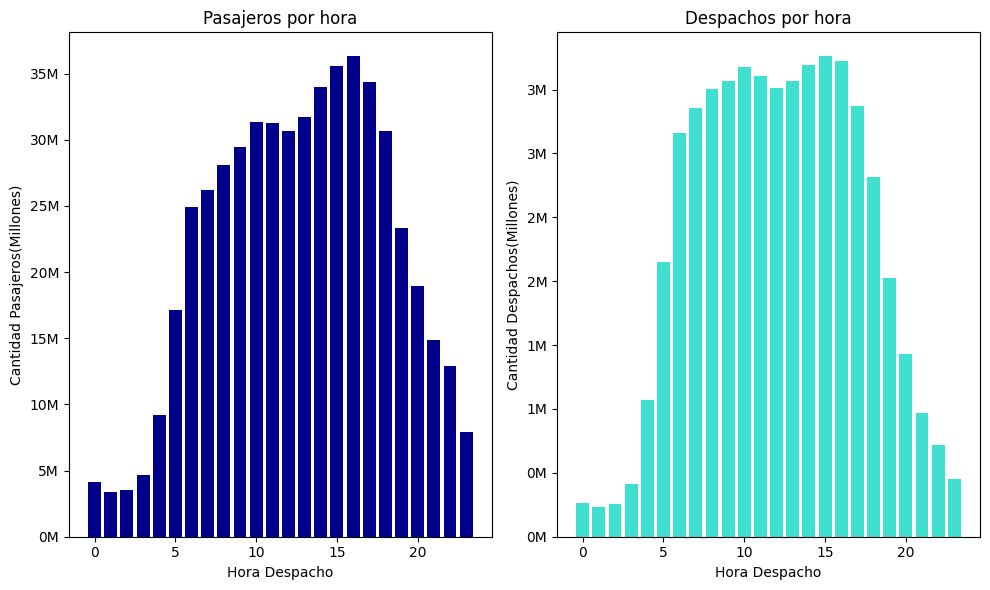

In [25]:
#Ahora observaremos los despachos y pasajeros por horas de despacho
data_por_hora_despacho = grupo_por_columna(data, 'HORA_DESPACHO')
#Calcular las roporciones por hora de despacho
data_por_hora_despacho['PORCENTAJE_PASAJEROS'] = ((data_por_hora_despacho['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_hora_despacho['PORCENTAJE_DESPACHOS'] = ((data_por_hora_despacho['DESPACHOS'] / total_despachos) * 100).round(2)
print('Tabla por hora despacho:')
print(data_por_hora_despacho.to_string(index=False))

#Máximos por Hora de despacho
hora_menos_despachos = data_por_hora_despacho.loc[data_por_hora_despacho['DESPACHOS'].idxmin()]
pasajeros_hora_menos_despachos = hora_menos_despachos['PASAJEROS']
hora_mas_despachos = data_por_hora_despacho.loc[data_por_hora_despacho['DESPACHOS'].idxmax()]
pasajeros_hora_mas_despachos = hora_mas_despachos['PASAJEROS']
print(f"Hora menos Despachos: {hora_menos_despachos['HORA_DESPACHO']}, Despachos:{hora_menos_despachos['DESPACHOS']}, Pasajeros:{pasajeros_hora_menos_despachos}")
print(f"Hora más Despachos: {hora_mas_despachos['HORA_DESPACHO']}, Despachos:{hora_mas_despachos['DESPACHOS']}, Pasajeros:{pasajeros_hora_mas_despachos}")

#Mínimos por hora de despacho
hora_menos_pasajeros = data_por_hora_despacho.loc[data_por_hora_despacho['PASAJEROS'].idxmin()]
despachos_hora_menos_pasajeros = hora_menos_pasajeros['DESPACHOS']
hora_mas_pasajeros = data_por_hora_despacho.loc[data_por_hora_despacho['PASAJEROS'].idxmax()]
despachos_hora_mas_pasajeros = hora_mas_despachos['DESPACHOS']
print(f"Hora menos Pasajeross: {hora_menos_pasajeros['HORA_DESPACHO']}, Pasajeros:{hora_menos_pasajeros['PASAJEROS']}, Despachos:{despachos_hora_menos_pasajeros}")
print(f"Hora más Pasajeros: {hora_mas_pasajeros['HORA_DESPACHO']}, Pasajeros:{hora_mas_pasajeros['PASAJEROS']}, Despachos:{despachos_hora_mas_pasajeros}")

#Gráfica 
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.bar(data_por_hora_despacho['HORA_DESPACHO'], data_por_hora_despacho['PASAJEROS'], color='darkblue')
plt.xlabel('Hora Despacho')
plt.ylabel('Cantidad Pasajeros(Millones)')
plt.title('Pasajeros por hora')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))


plt.subplot(1,2,2)
plt.bar(data_por_hora_despacho['HORA_DESPACHO'], data_por_hora_despacho['DESPACHOS'], color = 'turquoise')
plt.xlabel('Hora Despacho')
plt.ylabel('Cantidad Despachos(Millones)')
plt.title('Despachos por hora')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()

Es curioso ver que a pesar del saber común en el país donde se considera mejor viajar por la noche, la concentración de despachos y pasajeros se distribuye en horas del día, entre las 7a.m. y 6p.m.. Puede deberse a las condiciones de la carreteras en estos momentos o como veremos más adelante el destino de la mayoría de despachos ejecutados por departamento.

Tabla por clase de vehículo
  CLASE_VEHICULO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
1            BUS  248396777   19746462                 47.38   
6       MICROBUS  174867130   20176536                 33.35   
2         BUSETA   48282985    5864567                  9.21   
4      CAMIONETA   37268862    6171851                  7.11   
5        CAMPERO    7781914    1148818                  1.48   
0      AUTOMOVIL    7661614    2186118                  1.46   
7   TRACTOCAMION      44499       1335                  0.01   
3         CAMION         12          3                  0.00   

   PORCENTAJE_DESPACHOS  PASAJERO_PROM_POR_VEHÍCULO  
1                 35.71                       12.58  
6                 36.49                        8.67  
2                 10.61                        8.23  
4                 11.16                        6.04  
5                  2.08                        6.77  
0                  3.95                        3.50  
7                

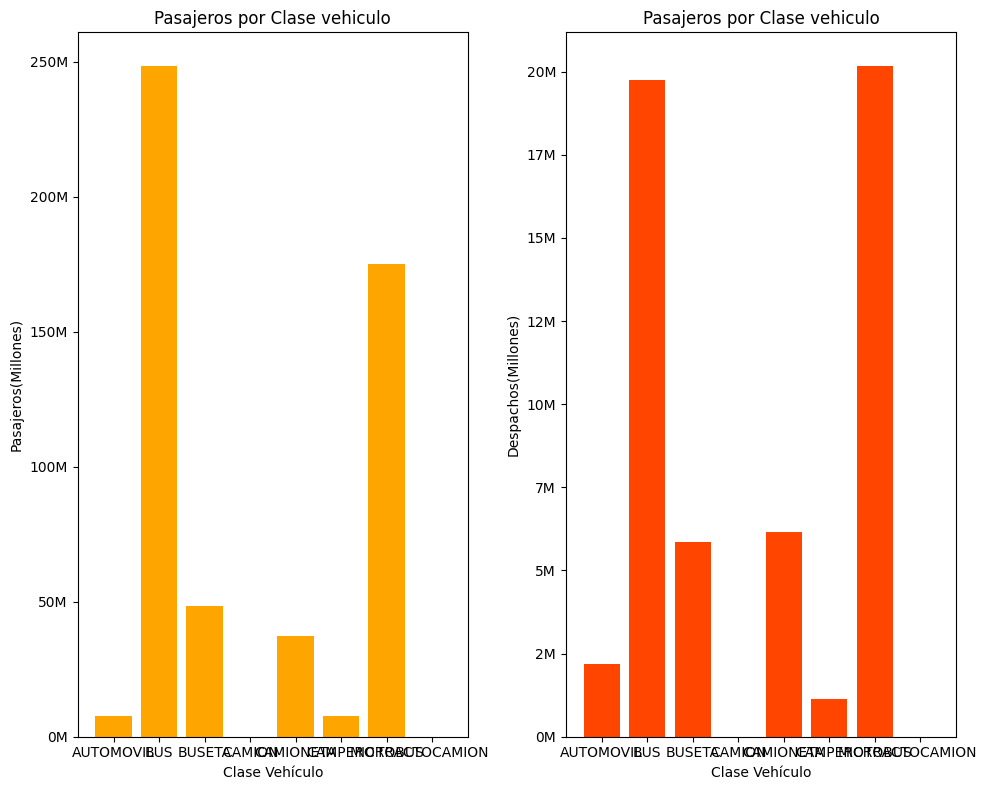

In [26]:
#Ahora se agrupará y presentarán los depachos y pasajeros por tipo de vehículo
data_por_vehiculo = grupo_por_columna(data, 'CLASE_VEHICULO')
#Proporciones por clase de vehículo
data_por_vehiculo['PORCENTAJE_PASAJEROS'] = ((data_por_vehiculo['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_vehiculo['PORCENTAJE_DESPACHOS'] = ((data_por_vehiculo['DESPACHOS'] / total_despachos) * 100).round(2)
data_por_vehiculo['PASAJERO_PROM_POR_VEHÍCULO'] = (data_por_vehiculo['PASAJEROS']/data_por_vehiculo['DESPACHOS']).round(2)
#Presentar resultados en formato de tabla
print('Tabla por clase de vehículo')
print(data_por_vehiculo.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.bar(data_por_vehiculo['CLASE_VEHICULO'], data_por_vehiculo['PASAJEROS'], color = 'orange')
plt.xlabel('Clase Vehículo')
plt.ylabel('Pasajeros(Millones)')
plt.title('Pasajeros por Clase vehiculo')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.bar(data_por_vehiculo['CLASE_VEHICULO'], data_por_vehiculo['DESPACHOS'], color = 'orangered')
plt.xlabel('Clase Vehículo')
plt.ylabel('Despachos(Millones)')
plt.title('Pasajeros por Clase vehiculo')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


Si bien la data parece recogerse a través de las terminales de transporte de cada departamento, la clase de vehículos contempla medios de transporte con bajo cupo de pasajeros (Automóvil, Camioneta y Campero), adicional parece que la camioneta ofrece capacidad de pasajeros casi similar a la buseta, según la proporción observada. Es curioso porque implica que son viajes personalizados adquiridos o que son de distancias cortas y que las Empresas de Transporte intermunicipal ofrecen servicio a este nivel de distribución.

Tabla por Nivel de Servicio
         NIVEL_SERVICIO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
1                  LUJO  320282244   33841859                 61.09   
0                BASICO  203825001   21444289                 38.88   
2  PREFERENCIAL DE LUJO     196548       9542                  0.04   

   PORCENTAJE_DESPACHOS  
1                 61.20  
0                 38.78  
2                  0.02  


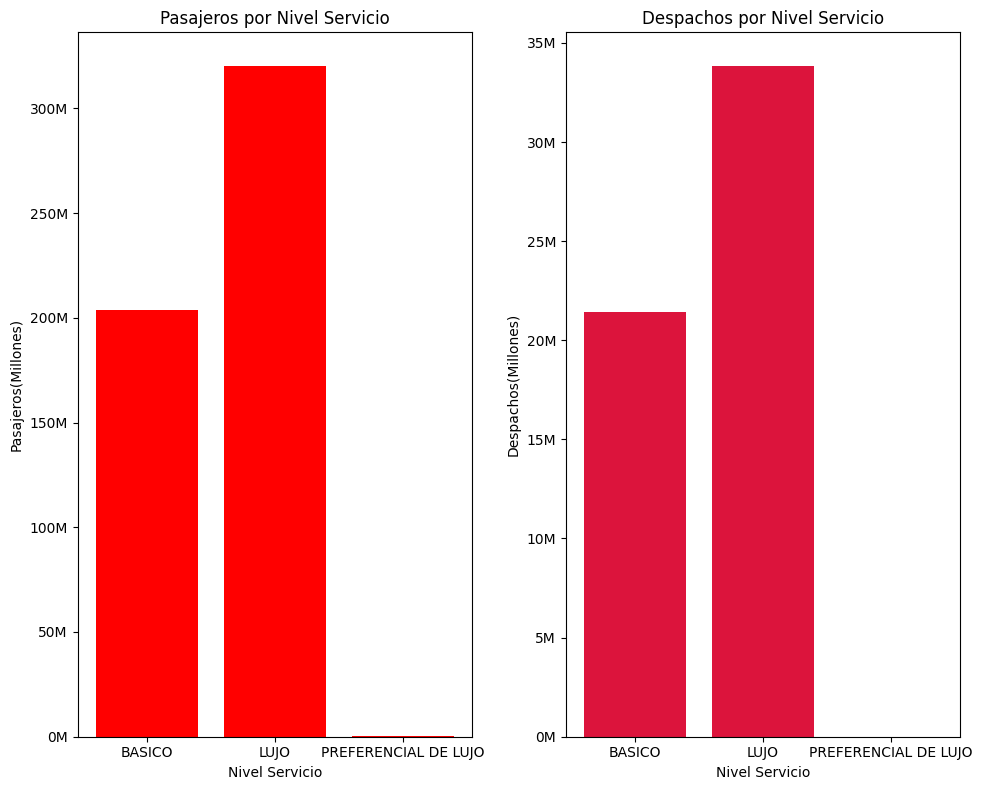

In [27]:
#Ahora se agrupará y presentarán los depachos y pasajeros por tipo de vehículo y se calcularán las proporciones por
#tipo de servicio
data_por_servicio = grupo_por_columna(data, 'NIVEL_SERVICIO')

#Proporciones por nivel de servicio
data_por_servicio['PORCENTAJE_PASAJEROS'] = ((data_por_servicio['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_servicio['PORCENTAJE_DESPACHOS'] = ((data_por_servicio['DESPACHOS'] / total_despachos) * 100).round(2)
print('Tabla por Nivel de Servicio')
print(data_por_servicio.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.bar(data_por_servicio['NIVEL_SERVICIO'], data_por_servicio['PASAJEROS'], color = 'red')
plt.xlabel('Nivel Servicio')
plt.ylabel('Pasajeros(Millones)')
plt.title('Pasajeros por Nivel Servicio')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.bar(data_por_servicio['NIVEL_SERVICIO'], data_por_servicio['DESPACHOS'], color = 'crimson')
plt.xlabel('Nivel Servicio')
plt.ylabel('Despachos(Millones)')
plt.title('Despachos por Nivel Servicio')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


In [28]:
#Dado que hay cierto tipo de vehículos cuya carga de pasajeros es más pequeña, se hará una observación de estos en varias
#de sus características
vehiculo_pequeño = grupo_por_columna(data, ['CLASE_VEHICULO', 'NIVEL_SERVICIO'])
vehiculo_pequeño = vehiculo_pequeño.loc[(vehiculo_pequeño['CLASE_VEHICULO'] == 'AUTOMOVIL') | (vehiculo_pequeño['CLASE_VEHICULO'] == 'CAMPERO')]
print('Data carros pequeños')
print(vehiculo_pequeño)

Data carros pequeños
   CLASE_VEHICULO        NIVEL_SERVICIO  PASAJEROS  DESPACHOS
0       AUTOMOVIL                BASICO    3310648     968588
1       AUTOMOVIL                  LUJO    4350753    1217483
2       AUTOMOVIL  PREFERENCIAL DE LUJO        213         47
13        CAMPERO                BASICO    5429571     746389
14        CAMPERO                  LUJO    2338345     400689
15        CAMPERO  PREFERENCIAL DE LUJO      13998       1740


Así bien, puede entenderse que el nivel de servicio preferencial de lujo debe ser un servicio adquirido de forma especial por agencia, mientras que lujo puede relacionarse a paquetes de turismo. No hay un diccionario en la data para entender esta referencia, así mismo, no se hace exclusivo de vehículos pequeños y puede observarse sobre los vehículos más grandes también.

Tabla por Departamento de Origen
   DEPARTAMENTO_ORIGEN  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
3         BOGOTÁ, D.C.   85434411    8888759                 16.29   
26     VALLE DEL CAUCA   77438661    8364350                 14.77   
0            ANTIOQUIA   65995610    6351103                 12.59   
5               BOYACÁ   37410265    4440102                  7.14   
21             QUINDÍO   24634697    3057190                  4.70   
22           RISARALDA   23878399    2630339                  4.55   
14               HUILA   24055677    2562763                  4.59   
18              NARIÑO   23013146    2340356                  4.39   
25              TOLIMA   22519567    2244579                  4.30   
6               CALDAS   14036385    1507389                  2.68   
19  NORTE DE SANTANDER   10065259    1399426                  1.92   
4              BOLÍVAR   15215346    1231098                  2.90   
13             CÓRDOBA   11086746    1137229             

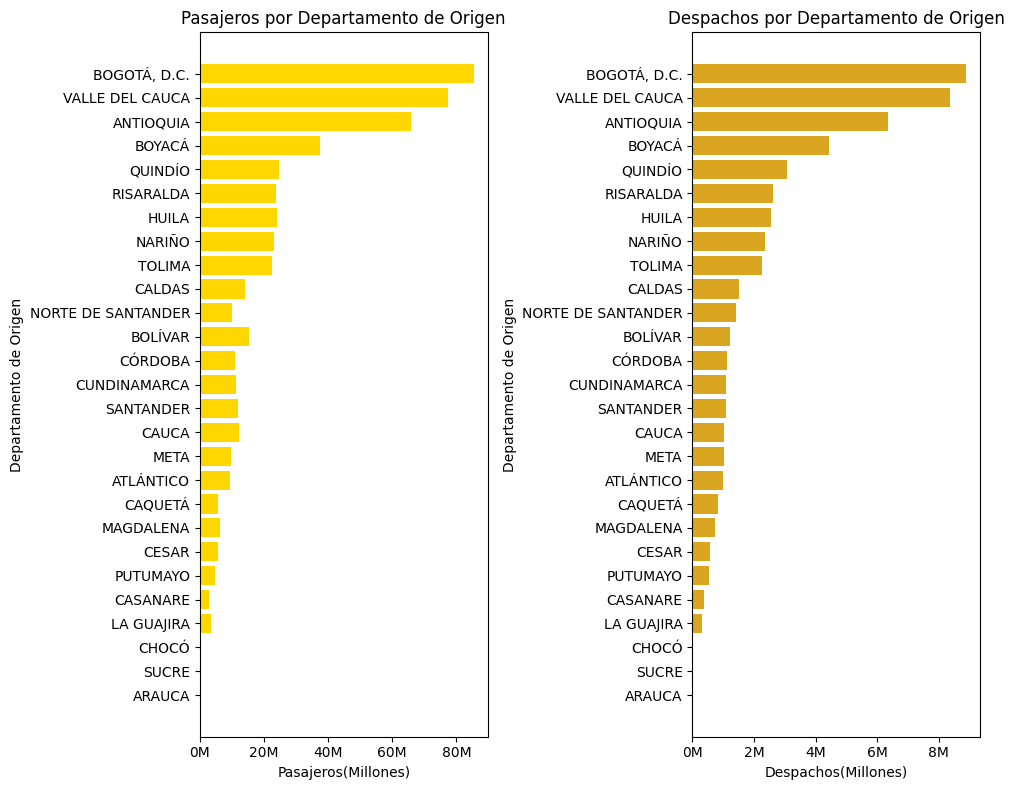

In [29]:
#Ahora se agrupará y presentarán los depachos y pasajeros departamento de origen
data_por_departamento_origen = grupo_por_columna(data, 'DEPARTAMENTO_ORIGEN')

#Proporciones por dapartamento de origne
data_por_departamento_origen['PORCENTAJE_PASAJEROS'] = ((data_por_departamento_origen['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_departamento_origen['PORCENTAJE_DESPACHOS'] = ((data_por_departamento_origen['DESPACHOS'] / total_despachos) * 100).round(2)

#En este caso se ordenarán de mayor a menos los valores por el campo de Despachos de esta forma para que 
#en la gráfica obtengamos este mismo orden
data_por_departamento_origen = data_por_departamento_origen.sort_values('DESPACHOS', ascending=False)

print('Tabla por Departamento de Origen')
print(data_por_departamento_origen)

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.barh(data_por_departamento_origen['DEPARTAMENTO_ORIGEN'], data_por_departamento_origen['PASAJEROS'], color = 'gold')
plt.xlabel('Pasajeros(Millones)')
plt.ylabel('Departamento de Origen')
plt.title('Pasajeros por Departamento de Origen')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.barh(data_por_departamento_origen['DEPARTAMENTO_ORIGEN'], data_por_departamento_origen['DESPACHOS'], color = 'goldenrod')
plt.xlabel('Despachos(Millones)')
plt.ylabel('Departamento de Origen')
plt.title('Despachos por Departamento de Origen')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


Tabla por Departamento de Destino
   DEPARTAMENTO_DESTINO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
27      VALLE DEL CAUCA   70300350    7178320                 13.41   
0             ANTIOQUIA   64862866    6536184                 12.37   
3          BOGOTÁ, D.C.   56737608    4002042                 10.82   
5                BOYACÁ   36616232    4612999                  6.98   
12         CUNDINAMARCA   31286449    4193423                  5.97   
22              QUINDÍO   24899548    2934542                  4.75   
19               NARIÑO   23523161    2332583                  4.49   
26               TOLIMA   21116941    2494282                  4.03   
15                HUILA   21034713    2489740                  4.01   
6                CALDAS   16373764    1895795                  3.12   
23            RISARALDA   15854909    1905293                  3.02   
24            SANTANDER   14778825    1528396                  2.82   
9                 CAUCA   14773595    15337

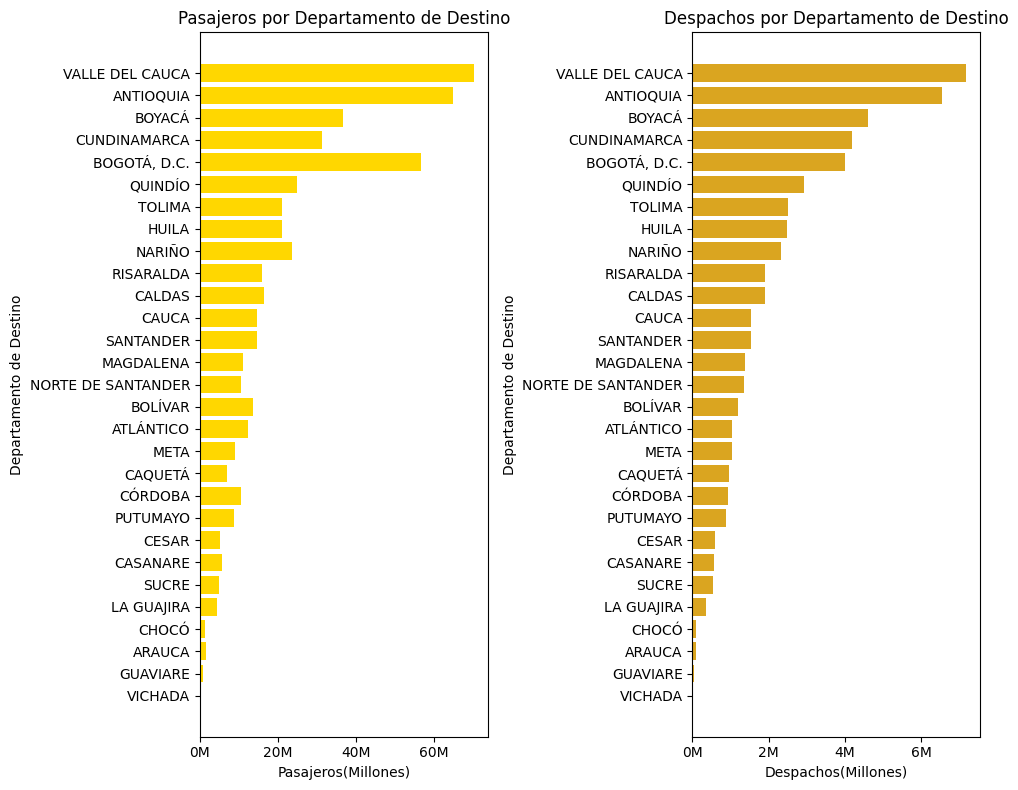

In [30]:
#Ahora se agrupará y presentarán los depachos y pasajeros por departamento de destino
data_por_departamento_destino = grupo_por_columna(data, 'DEPARTAMENTO_DESTINO')

#Proporciones por nivel de destino
data_por_departamento_destino['PORCENTAJE_PASAJEROS'] = ((data_por_departamento_destino['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_departamento_destino['PORCENTAJE_DESPACHOS'] = ((data_por_departamento_destino['DESPACHOS'] / total_despachos) * 100).round(2)

#En este caso se ordenarán de mayor a menos los valores por el campo de Despachos de esta forma para que 
#en la gráfica obtengamos este mismo orden
data_por_departamento_destino = data_por_departamento_destino.sort_values('DESPACHOS', ascending=False)

print('Tabla por Departamento de Destino')
print(data_por_departamento_destino.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.barh(data_por_departamento_destino['DEPARTAMENTO_DESTINO'], data_por_departamento_destino['PASAJEROS'], color = 'gold')
plt.xlabel('Pasajeros(Millones)')
plt.ylabel('Departamento de Destino')
plt.title('Pasajeros por Departamento de Destino')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.barh(data_por_departamento_destino['DEPARTAMENTO_DESTINO'], data_por_departamento_destino['DESPACHOS'], color = 'goldenrod')
plt.xlabel('Despachos(Millones)')
plt.ylabel('Departamento de Destino')
plt.title('Despachos por Departamento de Destino')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


La vista general entre origenes y destino, ofrece 2 focos de concentración interesantes. Gran cantidad de viajes salen desde la Capital del país y éste mismo se ubica en el 3er puesto de recepción de pasajeros, mientras que el Valle del Cauca, el departamento ubicado más al sur con gran afluencia en las variables, entrega el segundo punto de origenes de viajes y obtiene el primer puesto como destino predilecto de éstos. Seguidos de Antioquia entre los departamentos de renombre.

DEPARTAMENTO_DESTINO  ANTIOQUIA  ARAUCA  ATLÁNTICO  BOGOTÁ, D.C.  BOLÍVAR  \
DEPARTAMENTO_ORIGEN                                                         
ANTIOQUIA               5408484       0      29560         90662    52741   
ARAUCA                        0    1913          0          4449        0   
ATLÁNTICO                 29745       0        144         59022   194557   
BOGOTÁ, D.C.              63928   55123      34586          8284   124042   
BOLÍVAR                   35740       0     183863         86439   591607   
BOYACÁ                      149    1413          0        826353      359   
CALDAS                    72719       0          6         92818     4156   
CAQUETÁ                   20598       0      14847         46505      459   
CASANARE                    267    5226          0         99007        0   
CAUCA                      3469       0          0         14416       36   
CESAR                      7845       0      83403         27565     1713   

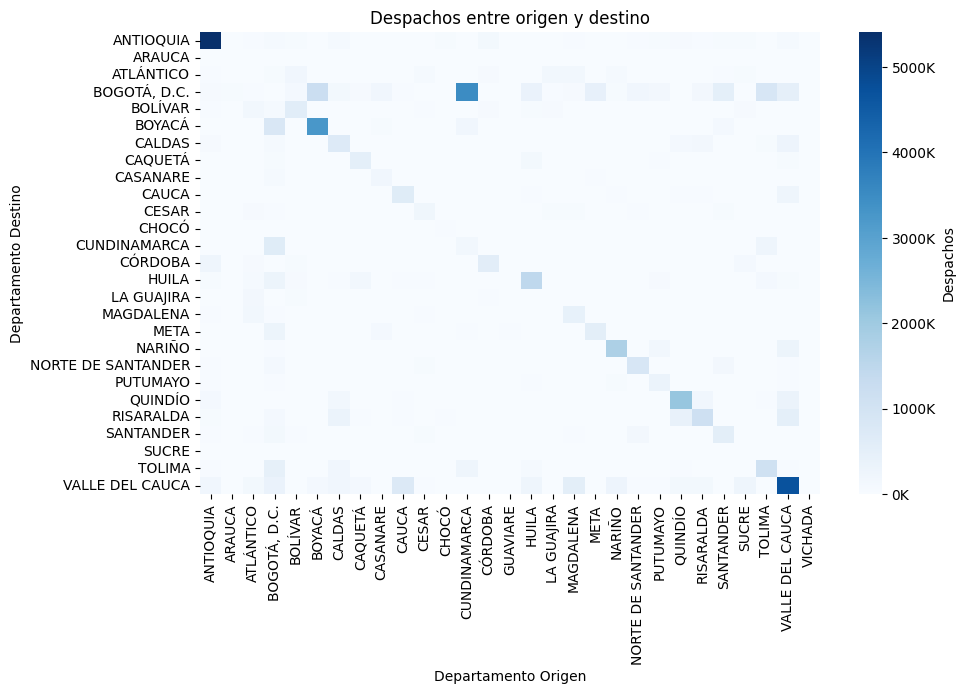

In [31]:
#Despachos entre origen y destino
origen_vs_destino = data.pivot_table(index = 'DEPARTAMENTO_ORIGEN', columns = 'DEPARTAMENTO_DESTINO',
                                      values = 'DESPACHOS', aggfunc='sum', fill_value=0)
print(origen_vs_destino)

#Fromato barra de color para el mapa de calor
def formato_mapa(x, pos):
    return f'{int(x/1e3)}K'
#Gráfica
plt.figure(figsize = (10,6))
sns.heatmap(origen_vs_destino, cmap = 'Blues', cbar_kws={'label': 'Despachos', 'format': FuncFormatter(formato_mapa)})
plt.title('Despachos entre origen y destino')
plt.xlabel('Departamento Origen')
plt.ylabel('Departamento Destino')
plt.show()

Básicamente viendo la distribución del mapa de calor, se explica de mejor forma el comportamiento de destino-origen y el tipo de vehículo implementado, puesto que esta data, fuera de lo esperado para el análisis en cuestión, presenta comportamiento de viajes sobretodo al interior de cada departamento, ubicando gran afluencia de, posiblemente, viajes de trabajo en municipios aledaños (por eso la distribución de horas), viajes de turismo cortos. O casos como el de Bogotá D.C. requerimientos, vueltas personales y de salud de comunidades del departamento de Cundinamarca que deben ir a la capital a suplir sus necesidades, entre otras razones más por explorar.

In [32]:
#Dada la distribución de los departamentos, es interesante observar la cantidad de destinos que estos realizan
dept_origen_destinos_unicos = grupo_por_columna(data,'DEPARTAMENTO_ORIGEN')
dept_origen_destinos_unicos['Municipios Origen Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['MUNICIPIO_ORIGEN'].nunique().reset_index(drop=True)
dept_origen_destinos_unicos['Destinos Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['DEPARTAMENTO_DESTINO'].nunique().reset_index(drop=True)
dept_origen_destinos_unicos['Municipios Destino Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['MUNICIPIO_DESTINO'].nunique().reset_index(drop=True)
print(dept_origen_destinos_unicos.sort_values('DESPACHOS', ascending=False))

   DEPARTAMENTO_ORIGEN  PASAJEROS  DESPACHOS  Municipios Origen Únicos  \
3         BOGOTÁ, D.C.   85434411    8888759                         1   
26     VALLE DEL CAUCA   77438661    8364350                        16   
0            ANTIOQUIA   65995610    6351103                        12   
5               BOYACÁ   37410265    4440102                        78   
21             QUINDÍO   24634697    3057190                         4   
22           RISARALDA   23878399    2630339                        12   
14               HUILA   24055677    2562763                        23   
18              NARIÑO   23013146    2340356                        10   
25              TOLIMA   22519567    2244579                        33   
6               CALDAS   14036385    1507389                        16   
19  NORTE DE SANTANDER   10065259    1399426                         9   
4              BOLÍVAR   15215346    1231098                         5   
13             CÓRDOBA   11086746    1

Sin embargo, la data general ofrece que los departamento principales distribuyen viajes y pasajeros a casi todos los departamentos posibles, lo cual hace que se deba implementar otras opciones de exploración para dar la explicación concreta del comportamiento de viajes en este conjunto de datos.

In [33]:
#Y en el caso contrario también
dept_destino_origen_unico = grupo_por_columna(data,'DEPARTAMENTO_DESTINO')
dept_destino_origen_unico['Origenes Únicos'] = data.groupby('DEPARTAMENTO_DESTINO')['DEPARTAMENTO_ORIGEN'].nunique().reset_index(drop=True)
print(dept_destino_origen_unico.sort_values('DESPACHOS', ascending=False))


   DEPARTAMENTO_DESTINO  PASAJEROS  DESPACHOS  Origenes Únicos
27      VALLE DEL CAUCA   70300350    7178320               21
0             ANTIOQUIA   64862866    6536184               25
5                BOYACÁ   36616232    4612999               16
12         CUNDINAMARCA   31286449    4193423               12
3          BOGOTÁ, D.C.   56737608    4002042               27
22              QUINDÍO   24899548    2934542               13
26               TOLIMA   21116941    2494282               17
15                HUILA   21034713    2489740               20
19               NARIÑO   23523161    2332583               15
23            RISARALDA   15854909    1905293               15
6                CALDAS   16373764    1895795               22
9                 CAUCA   14773595    1533761               11
24            SANTANDER   14778825    1528396               19
17            MAGDALENA   11106832    1379103               17
20   NORTE DE SANTANDER   10537797    1351699          

In [34]:
mun_destino_origen_unico = grupo_por_columna(data,'MUNICIPIO_DESTINO')
mun_destino_origen_unico['Origenes Únicos'] = data.groupby('MUNICIPIO_DESTINO')['MUNICIPIO_ORIGEN'].nunique().reset_index(drop=True)
print(mun_destino_origen_unico.sort_values('DESPACHOS', ascending=False))

    MUNICIPIO_DESTINO  PASAJEROS  DESPACHOS  Origenes Únicos
80       BOGOTÁ, D.C.   56737608    4002042              219
633  SANTIAGO DE CALI   29198953    2302466               86
428             NEIVA    9138735    1032157               61
658          SOGAMOSO   10010888     982470               46
309            IBAGUÉ    8515221     909601               47
..                ...        ...        ...              ...
370    LÓPEZ DE MICAY         12          1                1
561           SALDAÑA          3          1                1
78            BITUIMA         17          1                1
535          REMOLINO          8          1                1
223          EL PIÑÓN          3          1                1

[784 rows x 4 columns]


In [35]:
mun_origen_destino_unico = grupo_por_columna(data,'MUNICIPIO_ORIGEN')
mun_origen_destino_unico['Destinos Únicos'] = data.groupby('MUNICIPIO_ORIGEN')['MUNICIPIO_DESTINO'].nunique().reset_index(drop=True)
print(mun_origen_destino_unico.sort_values('DESPACHOS', ascending=False))

     MUNICIPIO_ORIGEN  PASAJEROS  DESPACHOS  Destinos Únicos
41       BOGOTÁ, D.C.   85434411    8888759              312
299  SANTIAGO DE CALI   58440954    6235217              103
175          MEDELLÍN   57794604    4979414              171
23            ARMENIA   24641874    3057735               42
222           PEREIRA   23874903    2629798               54
..                ...        ...        ...              ...
69            CHITAGÁ          4          1                1
121           GIGANTE         11          1                1
332              TOTA         20          1                1
65              CHIMÁ         15          1                1
359     ZONA BANANERA          6          1                1

[360 rows x 4 columns]


### **Observación General**

La data recolectada, si bien menciona que se origina desde cada Terminal registrada, puede ahondarse en dar mayor claridad sobre el nivel de servicio mencionado, y gracias a data de otras fuentes podría darse explicaciones más profundas en el asunto. Así mismo, la concentración de viajes al interior de cada departamento, puedría considerar poder ampliar las características de registro de información, conociendo el tipo de viaje realizado en ciertos pasajeros. Es un conjunto apto para conocer el comportamiento de pasajeros, y el fin principal de análisis no hay información explícita sobre las compañías que registraron la data, para dar una mayor relación en la partipación de éstas, la recuperación de sus servicios desde la pandemia y demás características para indagar en el portafolio ofrecido.

In [36]:
# Nombre del archivo Excel en el que se guardarán las hojas
#nombre_archivo_excel = 'TablasPruebaPinbusDC.xlsx'

# Crear un objeto ExcelWriter para guardar los DataFrames en un archivo Excel
#writer = pd.ExcelWriter(nombre_archivo_excel, engine='xlsxwriter')

# Escribir cada DataFrame en una hoja separada en el archivo Excel
#data_agrupada.to_excel(writer, sheet_name='Tendencia y variación Mensual', index=False)
#tendencia_anual_por_departamento.to_excel(writer, sheet_name='Tendencia Anual Departamento', index=False)
#tendencia_anual_por_departamento_mes.to_excel(writer, sheet_name='Tendencia Mensual Departamento', index=False)
#data_por_hora_despacho.to_excel(writer, sheet_name='Desp&Pas Hora Despacho', index=False)
#data_por_vehiculo.to_excel(writer, sheet_name='Desp6Pas Tipo Vehiculo', index=False)
#data_por_servicio.to_excel(writer, sheet_name='Desp6Pas Nivel de Servicio', index=False)
#data_por_departamento_origen.to_excel(writer, sheet_name='Des&Pas Departamento Origen', index=False)
#data_por_departamento_destino.to_excel(writer, sheet_name='Desp&Pas Departamento Destino', index=False)
#origen_vs_destino.to_excel(writer, sheet_name='Desp&Pas Origen-Destino', index=False)
#dept_origen_destinos_unicos.to_excel(writer, sheet_name='Destinos Unicos por Origen', index=False)
#dept_destino_origen_unico.to_excel(writer, sheet_name='Origen Unico por Destino', index=False)

# Guardar el archivo Excel
#writer.close()

#print("DataFrames guardados en el archivo Excel con hojas separadas.")
